In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
%matplotlib inline

In [2]:
from IPython.display import HTML, display

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

sns.set_style("darkgrid")
sns.set_context("poster")

In [3]:
# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
opioids = pd.read_csv('opioids.csv')
overdoses = pd.read_csv('overdoses.csv', thousands = ',')
prescriber = pd.read_csv('prescriber_cap.csv')

In [5]:
overdoses= overdoses[['Abbrev', 'Population', 'Deaths']]

In [6]:
#Merge Overdoses DF on Prescriber DF
prescriber = pd.merge(prescriber, overdoses, on=['Abbrev'], how='outer')

In [7]:
prescriber.rename(columns={'Opioid.Prescriber': 'Opioid_Prescriber'}, inplace=True)

In [10]:
prescriber

,NPI,Gender,Abbrev,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid_Prescriber,SumOpi,TotPresc,NonOpi,Region,Population,Deaths,Spec_group
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,1,17,29,12,South,26448193,2601,group1
1,1023260569,M,TX,Optometry,0,0,0,0,0,0,...,0,0,0,0,144,144,South,26448193,2601,group1
2,1659334472,M,TX,General Surgery,0,0,0,0,0,0,...,0,0,1,17,17,0,South,26448193,2601,group1
3,1952598419,F,TX,Hematology/Oncology,0,0,16,0,0,0,...,0,12,1,155,734,579,South,26448193,2601,group1
4,1043399322,M,TX,Urology,0,23,0,0,0,0,...,0,0,1,132,1222,1090,South,26448193,2601,group1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24754,1841302700,M,SD,Optometry,0,0,0,0,0,0,...,0,0,0,0,223,223,Central,844877,63,group1
24755,1336293323,F,SD,Nurse Practitioner,20,0,0,0,0,0,...,52,59,0,0,1322,1322,Central,844877,63,group1
24756,1851630727,M,SD,Physician Assistant,13,0,0,0,0,0,...,0,0,1,66,1191,1125,Central,844877,63,group1
24757,1447239942,F,SD,Physician Assistant,0,0,0,0,0,0,...,0,0,0,0,24,24,Central,844877,63,group1


In [23]:
prescriber

,NPI,Gender,Abbrev,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid_Prescriber,SumOpi,TotPresc,NonOpi,Region,Population,Deaths,Spec_group
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,1,17,29,12,South,26448193,2601,group1
1,1023260569,M,TX,Optometry,0,0,0,0,0,0,...,0,0,0,0,144,144,South,26448193,2601,group1
2,1659334472,M,TX,General Surgery,0,0,0,0,0,0,...,0,0,1,17,17,0,South,26448193,2601,group1
3,1952598419,F,TX,Hematology/Oncology,0,0,16,0,0,0,...,0,12,1,155,734,579,South,26448193,2601,group1
4,1043399322,M,TX,Urology,0,23,0,0,0,0,...,0,0,1,132,1222,1090,South,26448193,2601,group1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24754,1841302700,M,SD,Optometry,0,0,0,0,0,0,...,0,0,0,0,223,223,Central,844877,63,group1
24755,1336293323,F,SD,Nurse Practitioner,20,0,0,0,0,0,...,52,59,0,0,1322,1322,Central,844877,63,group1
24756,1851630727,M,SD,Physician Assistant,13,0,0,0,0,0,...,0,0,1,66,1191,1125,Central,844877,63,group1
24757,1447239942,F,SD,Physician Assistant,0,0,0,0,0,0,...,0,0,0,0,24,24,Central,844877,63,group1


## Linear Regression - Statistical

In [403]:
# We'll use an updated dataframe that has some unnecessary columns found in the prescriber df already taken out
df

,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,...,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid_Prescriber,Population,Deaths
0,M,TX,Dentist,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,26448193,2601
1,M,TX,Optometry,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,26448193,2601
2,M,TX,General Surgery,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,26448193,2601
3,F,TX,Hematology/Oncology,0,16,0,0,0,0,22,...,0,0,40,54,0,0,12,1,26448193,2601
4,M,TX,Urology,0,0,0,0,0,0,12,...,0,0,0,0,0,0,0,1,26448193,2601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24754,M,SD,Optometry,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,844877,63
24755,F,SD,Nurse Practitioner,20,0,0,0,0,0,16,...,0,0,0,0,0,52,59,0,844877,63
24756,M,SD,Physician Assistant,13,0,0,0,0,14,0,...,0,0,12,0,0,0,0,1,844877,63
24757,F,SD,Physician Assistant,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,844877,63


In [163]:
fit_spec = ols('Opioid_Prescriber ~ C(Specialty)', data=df).fit()

fit_spec_summary = fit_spec.summary()

HTML(
(fit_spec_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

In [165]:
fit_spec2 = ols('Opioid_Prescriber ~ C(Specialty) + C(Gender)', data=df).fit()

fit_spec2_summary = fit_spec2.summary()

HTML(
(fit_spec2_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

In [166]:
fit_spec3 = ols('Opioid_Prescriber ~ C(Specialty) + C(Gender) + C(State)', data= df).fit()

fit_spec3_summary = fit_spec3.summary()

HTML(
(fit_spec3_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

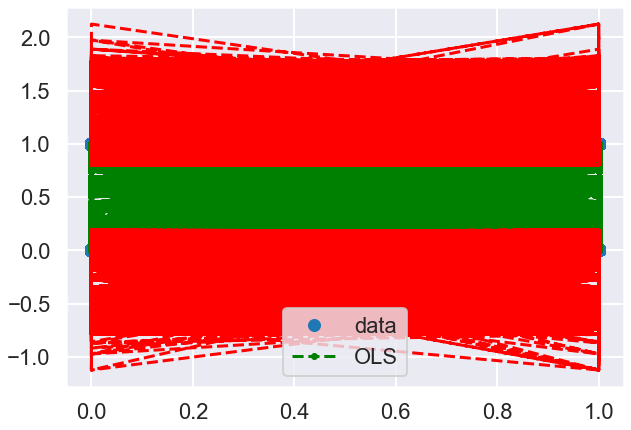

In [406]:
# predictor variable (x) and dependent variable (y)
x = pd.get_dummies(prescriber[['Gender']], drop_first=True)
y = prescriber[['Opioid_Prescriber']]

# Retrieve our confidence interval values
# _ is a dummy variable since we don't actually use it for plotting but need it as a placeholder
# since wls_prediction_std() returns 3 values
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(fit_spec)

fig, ax = plt.subplots(figsize=(10,7))

# plot the dots
# 'o' specifies the shape (circle), we can also use 'd' (diamonds), 's' (squares)
ax.plot(x, y, 'o', label="data")

# plot the trend line
# g-- and r-- specify the color to use
ax.plot(x, fit_spec.fittedvalues, 'g--.', label="OLS")

# plot upper and lower ci values
ax.plot(x, confidence_interval_upper, 'r--')
ax.plot(x, confidence_interval_lower, 'r--')

# plot legend
ax.legend(loc='best');

## Linear Regression - ML

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [178]:
X1 = prescriber[['Gender', 'Spec_group', 'Region', 'Population']]
y1 = prescriber['Opioid_Prescriber']

In [179]:
X1 = pd.get_dummies(X1, drop_first=True)

X1

,Population,Gender_M,Spec_group_group2,Spec_group_group3,Spec_group_group4,Region_North East,Region_South,Region_West
0,26448193,1,0,0,0,0,1,0
1,26448193,1,0,0,0,0,1,0
2,26448193,1,0,0,0,0,1,0
3,26448193,0,0,0,0,0,1,0
4,26448193,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
24754,844877,1,0,0,0,0,0,0
24755,844877,0,0,0,0,0,0,0
24756,844877,1,0,0,0,0,0,0
24757,844877,0,0,0,0,0,0,0


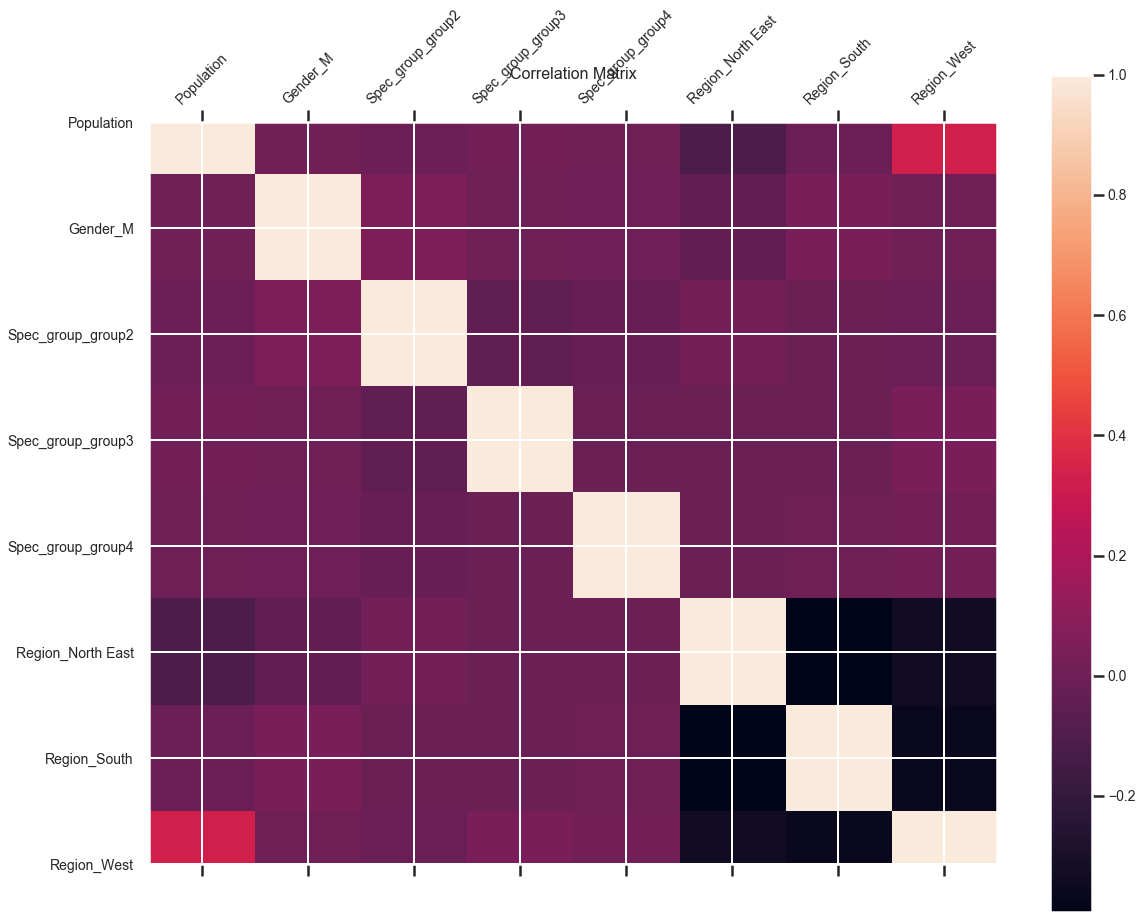

In [185]:
f = plt.figure(figsize=(19, 15))
plt.matshow(X1.corr(), fignum=f.number)
plt.xticks(range(X1.shape[1]), X1.columns, fontsize=14, rotation=45)
plt.yticks(range(X1.shape[1]), X1.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [184]:
X1.corr()

,Population,Gender_M,Spec_group_group2,Spec_group_group3,Spec_group_group4,Region_North East,Region_South,Region_West
Population,1.000000,0.014512,-0.003545,0.017702,0.002590,-0.111386,-0.004923,0.333492
Gender_M,0.014512,1.000000,0.047810,0.001664,0.007388,-0.035190,0.041583,-0.000417
Spec_group_group2,-0.003545,0.047810,1.000000,-0.041641,-0.020769,0.020412,-0.009878,-0.016717
Spec_group_group3,0.017702,0.001664,-0.041641,1.000000,-0.007152,-0.011314,-0.010481,0.038938
Spec_group_group4,0.002590,0.007388,-0.020769,-0.007152,1.000000,-0.008499,0.001264,0.017112
Region_North East,-0.111386,-0.035190,0.020412,-0.011314,-0.008499,1.000000,-0.392963,-0.331643
Region_South,-0.004923,0.041583,-0.009878,-0.010481,0.001264,-0.392963,1.000000,-0.356796
Region_West,0.333492,-0.000417,-0.016717,0.038938,0.017112,-0.331643,-0.356796,1.000000


In [200]:
#train_test_split(X, y, test_size=0.4, random_state=101
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.4, random_state = 101)
regr = linear_model.LinearRegression() # Do not use fit_intercept = False if you have removed 1 column after dummy encoding
regr.fit(X_train, y_train)
predicted = regr.predict(X_test)

In [201]:
lm1 = LinearRegression()
lm1.fit(X_train, y_train)

predictions = lm1.predict(X_test)

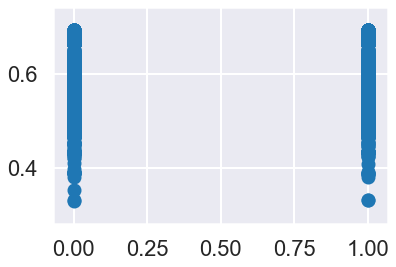

In [202]:
plt.scatter(y_test, predictions)

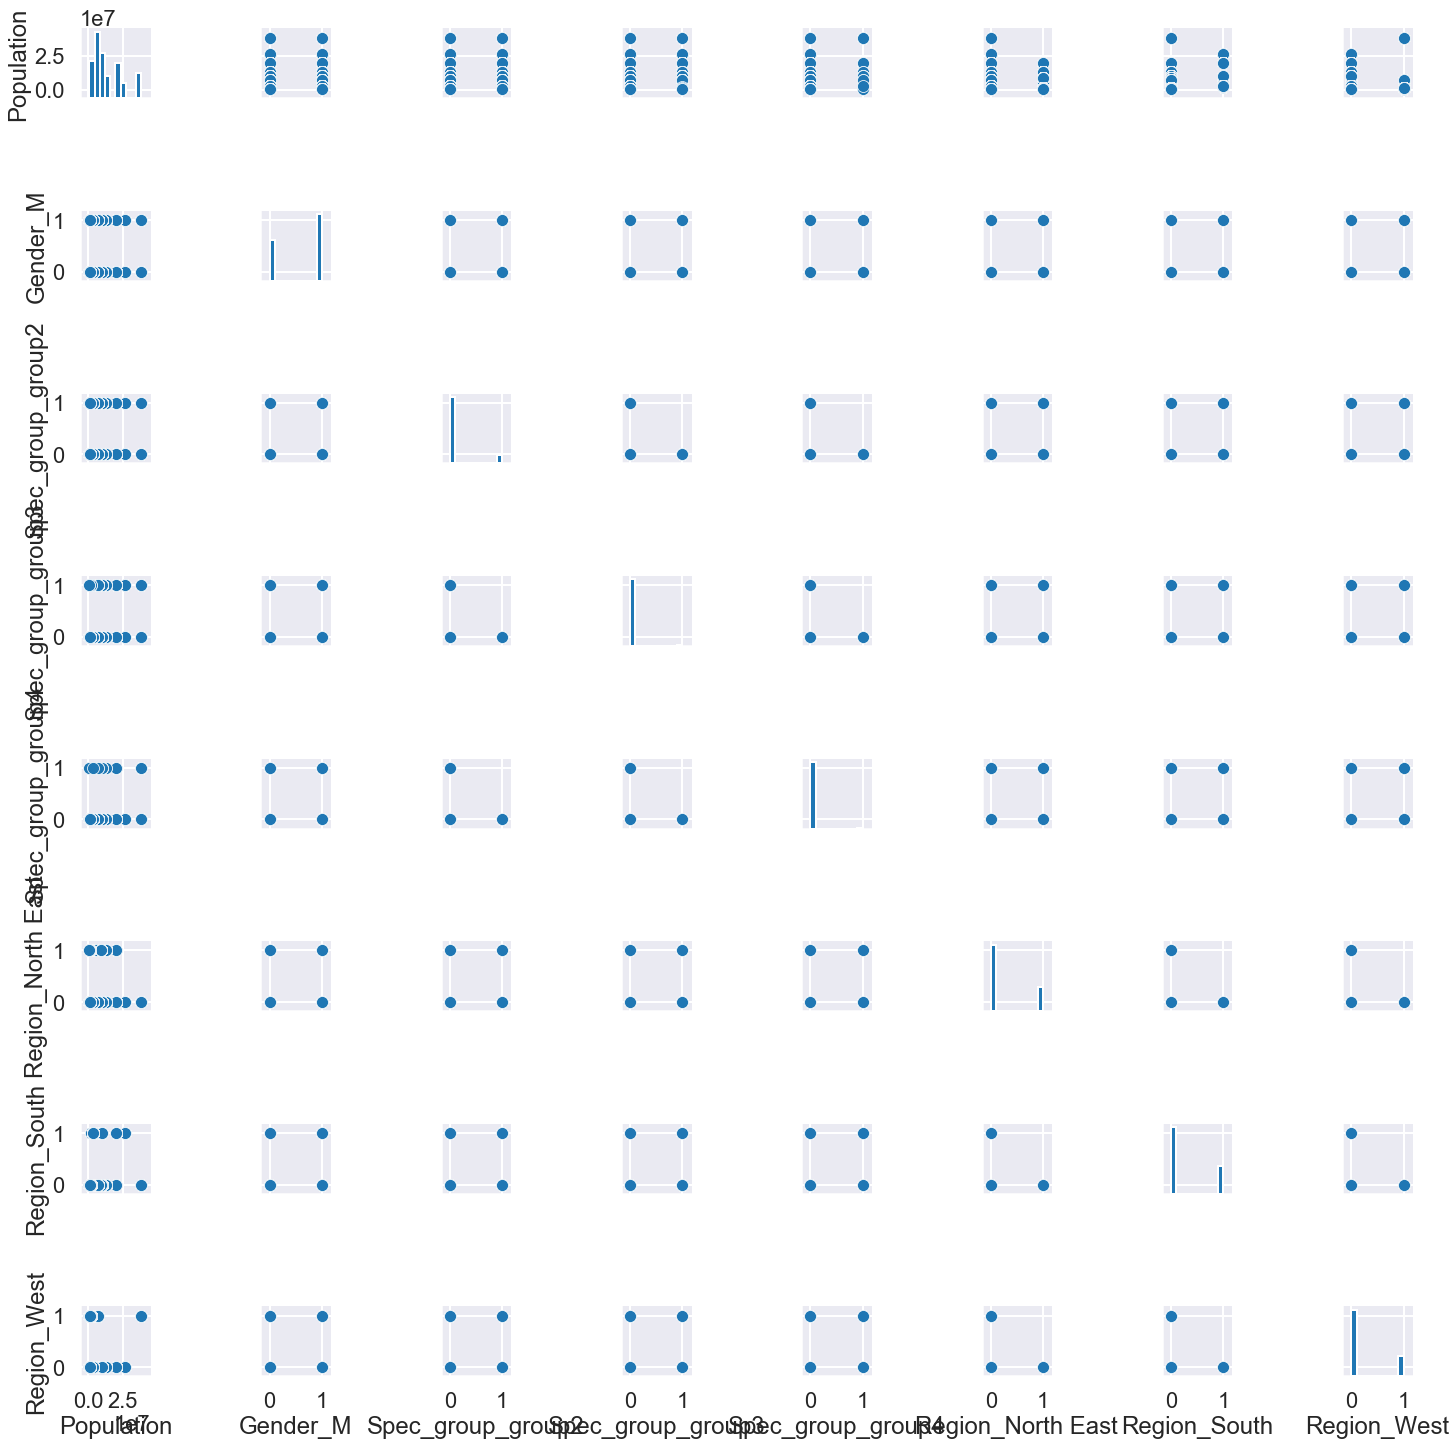

In [408]:
sns.pairplot(X1)

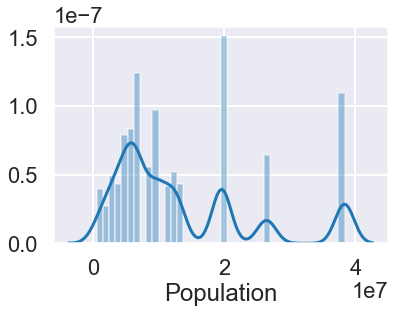

In [207]:
sns.distplot(X1['Population'])

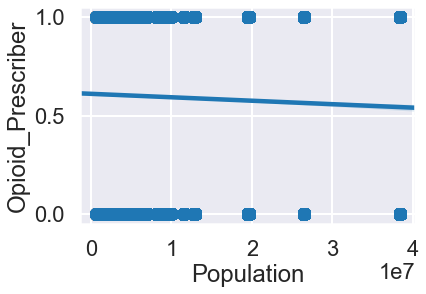

In [412]:
sns.regplot(y="Opioid_Prescriber", x="Population", data= df, fit_reg = True)

## Clustering

In [310]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

import matplotlib.cm as cm

In [354]:
df_new = prescriber[['NPI', 'Specialty']]
df_call = prescriber[['NPI', 'Region', 'Opioid_Prescriber', 'Population']]

In [355]:
df_new['N'] = 1

C:\Users\Jimsyd\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [356]:
df_merge = pd.merge(df_new, df_call, how='left', on='NPI')

In [357]:
df_pivot = df_merge.pivot_table(index='Specialty', columns='NPI', values='N').fillna(0)

In [358]:
df_pivot

NPI,1003002320,1003004771,1003008475,1003009630,1003016270,1003019019,1003022872,1003023193,1003024894,1003026055,...,1992975361,1992979215,1992980619,1992981484,1992983498,1992989776,1992992549,1992994776,1992996631,1992998611
Specialty,,,,,,,,,,,,,,,,,,,,,
Addiction Medicine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Allergy/Immunology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anesthesiology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Behavioral Analyst,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CRNA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thoracic Surgery (Cardiothoracic Vascular Surgery),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unknown Physician Specialty Code,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unknown Supplier/Provider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [336]:
df_merge

,NPI,Spec_group,N,Region,Opioid_Prescriber,Population
0,1710982582,group1,1,South,1,26448193
1,1023260569,group1,1,South,0,26448193
2,1659334472,group1,1,South,1,26448193
3,1952598419,group1,1,South,1,26448193
4,1043399322,group1,1,South,1,26448193
...,...,...,...,...,...,...
24754,1841302700,group1,1,Central,0,844877
24755,1336293323,group1,1,Central,0,844877
24756,1851630727,group1,1,Central,1,844877
24757,1447239942,group1,1,Central,0,844877


In [361]:
x_cols = df_pivot.values
x_cols[:3,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [362]:
model = KMeans(n_clusters = 5, random_state = 0)
model.fit(x_cols)

print(model.labels_)
print(model.cluster_centers_)
print(model.inertia_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[ 9.61538462e-03  9.61538462e-03 -1.56125113e-17 ... -1.56125113e-17
   9.61538462e-03  9.61538462e-03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
14143.682692307699


In [363]:
ks = np.arange(1,11)
SS = []

for k in ks:
    model = KMeans(n_clusters = k, random_state = 10)
    model.fit(x_cols)
    SS.append(model.inertia_)

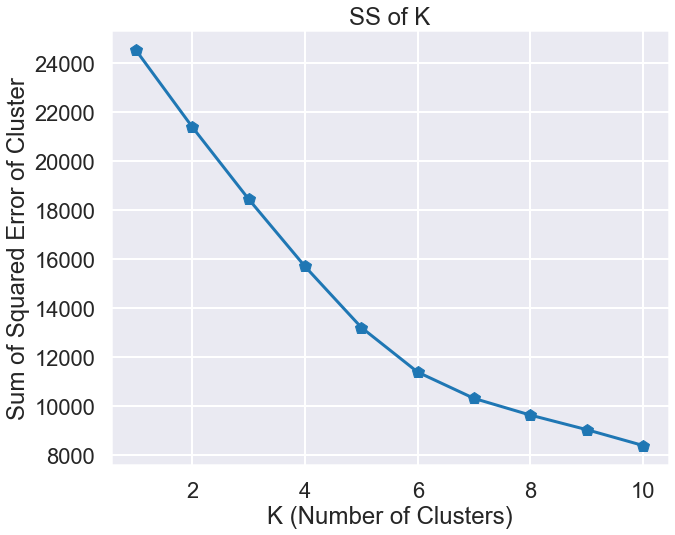

In [364]:
#Plot SS of k
plt.figure(figsize=(10,8))
plt.plot(ks, SS, marker= 'p')
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Sum of Squared Error of Cluster')
plt.title('SS of K')
plt.show()

Text(0.5, 0, 'Cluster')

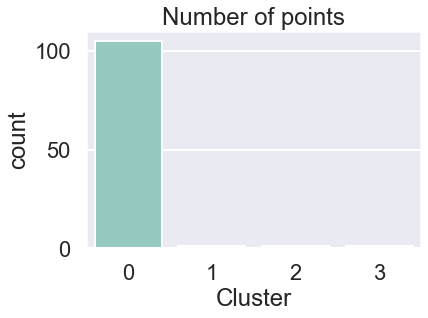

In [365]:
# Training kmeans model with the best K of 4
model_knm = KMeans(n_clusters= 4, random_state = 10).fit(x_cols)

sns.countplot(model_knm.labels_, palette = "Set3" )
plt.title("Number of points")
plt.xlabel('Cluster')

For n_clusters = 2 The average silhouette score is : 0.7385895905628467
For n_clusters = 3 The average silhouette score is : 0.735595028717375
For n_clusters = 4 The average silhouette score is : 0.7322158521546221
For n_clusters = 5 The average silhouette score is : 0.7255088505456047
For n_clusters = 6 The average silhouette score is : 0.6931152505281365
For n_clusters = 7 The average silhouette score is : 0.6264124346791179
For n_clusters = 8 The average silhouette score is : 0.5599730139037293
For n_clusters = 9 The average silhouette score is : 0.5427044774047799
For n_clusters = 10 The average silhouette score is : 0.53705148662014


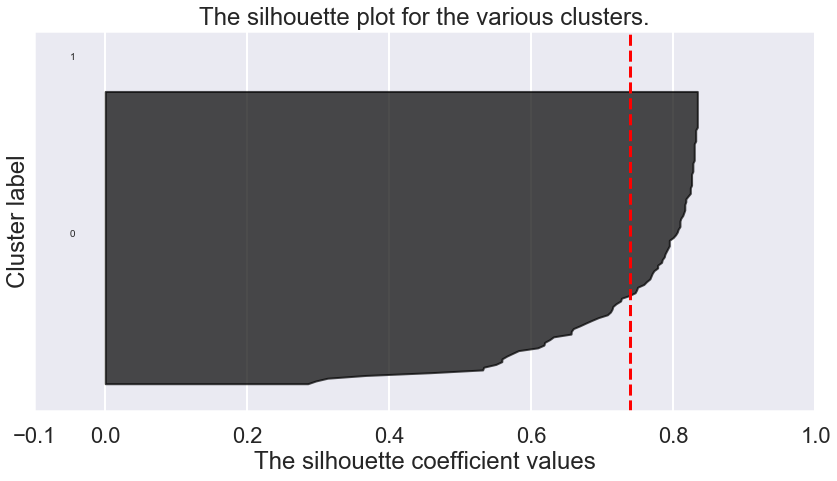

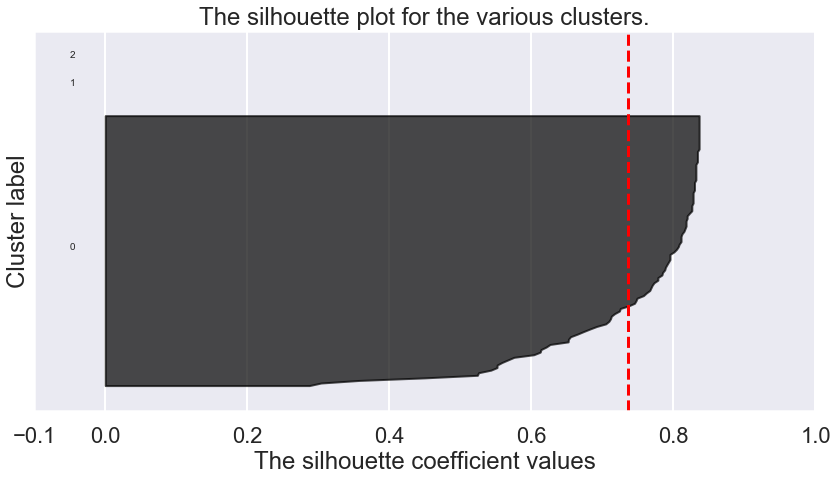

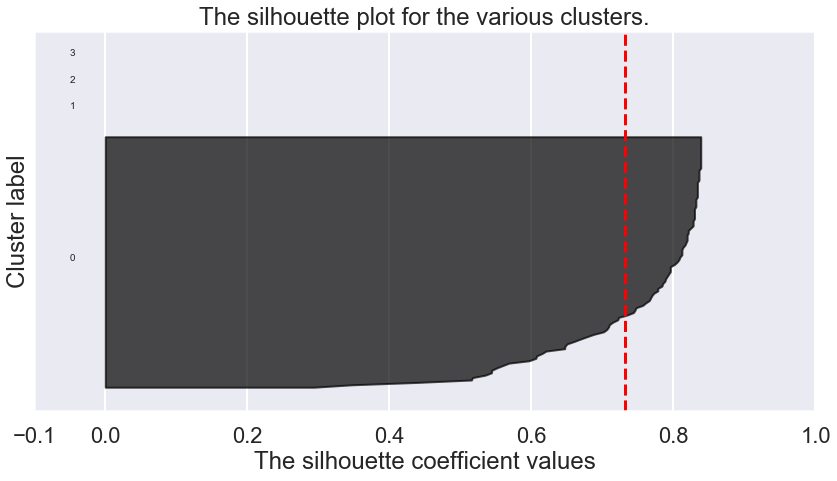

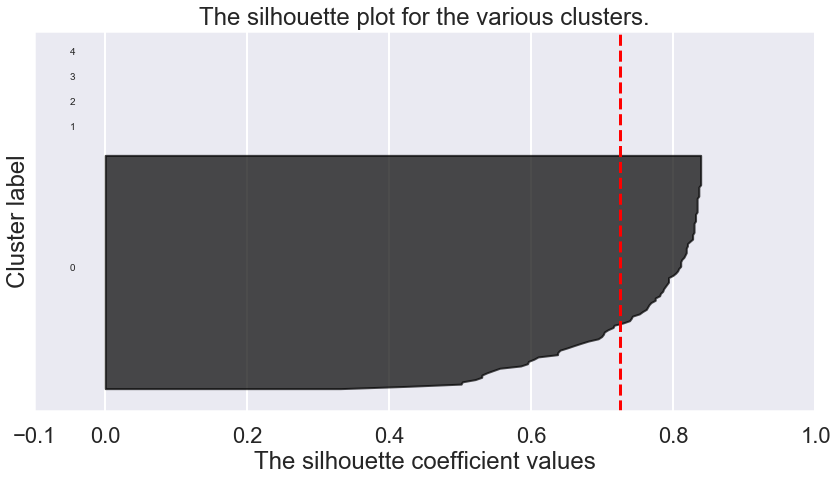

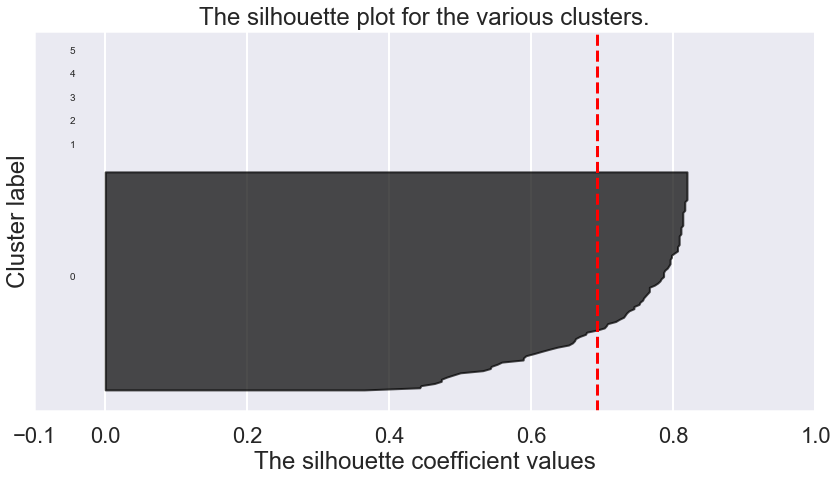

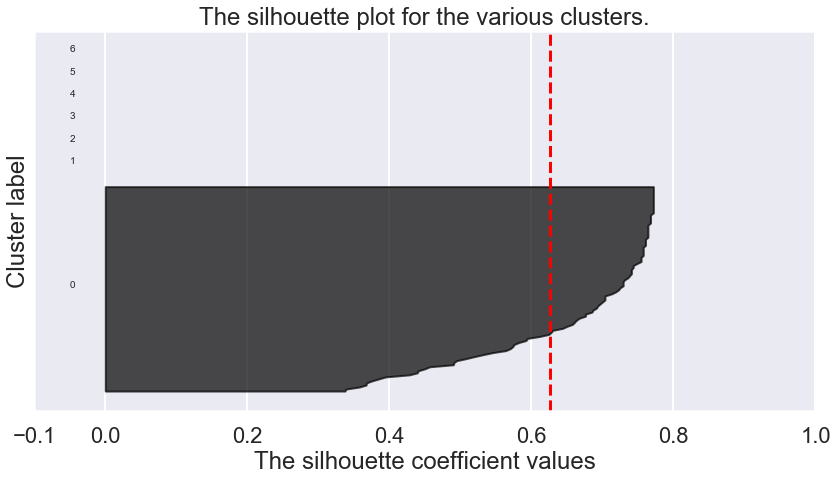

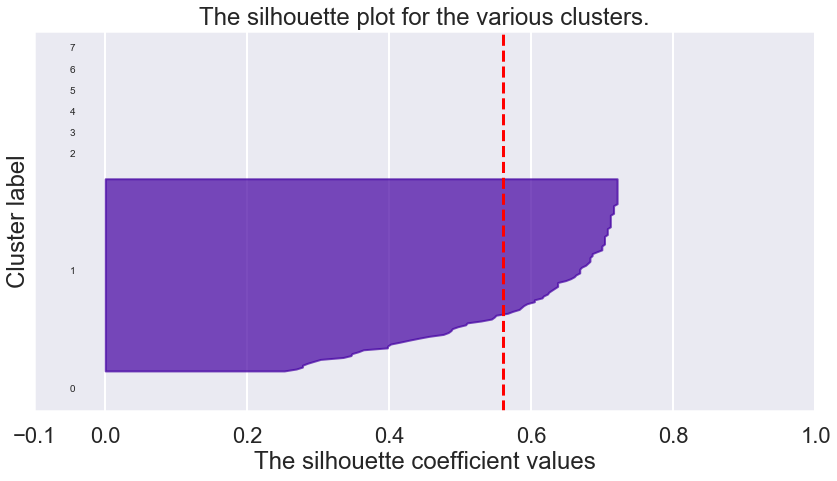

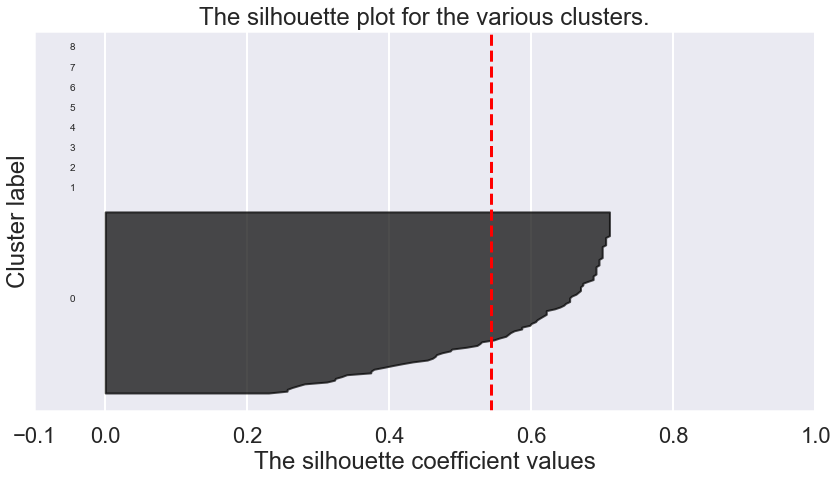

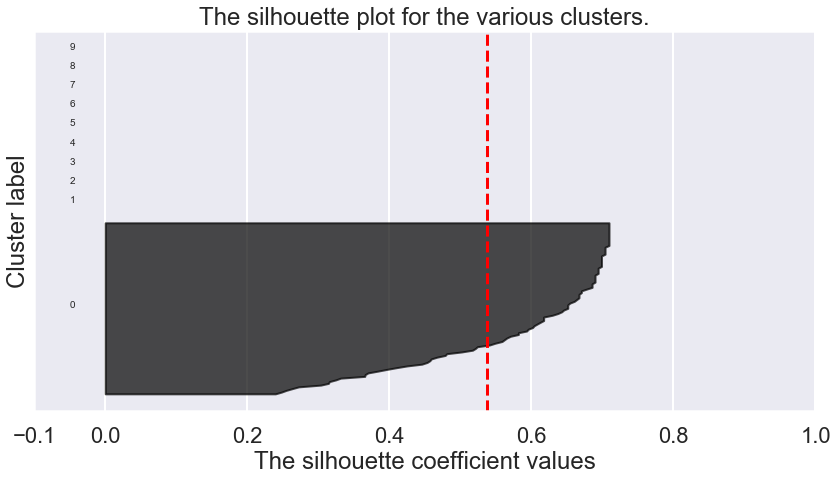

In [366]:
range_n_clusters = np.arange(2,11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    #Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(14,7)
    
    #1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])
    
    #Initialize the cluster with n_clusters value and random state of 10
    clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(x_cols)
    
    #Average value for all samples through silhouette_score
    sil_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_scores.append(sil_avg)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette score is :", sil_avg)
    
    #Silhouette score of each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        # Sort scores for samples of cluster i 
        ith_cluster_silhouette_values.sort()
        
        # Obtain shape to add with y_lower scaling for y
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
     # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

   

plt.show()

Text(0.5, 1.0, 'Average Silhouette Scores for $k$')

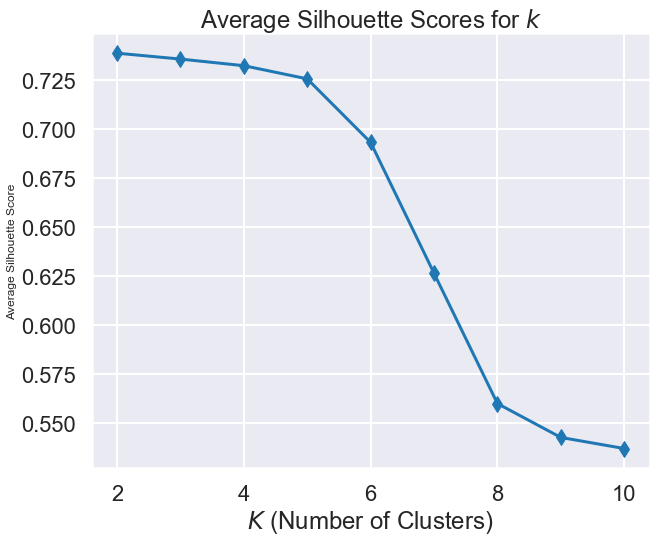

In [367]:
# Plot the Silhouette score for k = 2-10 clusters
plt.figure(figsize=(10,8))
plt.plot(range_n_clusters,silhouette_scores, marker='d')
plt.xlabel('$K$ (Number of Clusters)')
plt.ylabel('Average Silhouette Score', size = 12)
plt.title('Average Silhouette Scores for $k$')

In [374]:
#Using the PCA function to reduce the dimensionality of clustering to 2 components
pca = PCA(n_components=2)
components = pca.fit_transform(x_cols)

model = KMeans(n_clusters=6, random_state=10)
labels = model.fit(x_cols).labels_

model_2 = KMeans(n_clusters=3, random_state=10)
labels_2 = model_2.fit(x_cols).labels_

df_pca = pd.DataFrame()
df_pca['Specialty'] = df_pivot.index
df_pca['Cluster_1'] = labels
df_pca['Cluster_2'] = labels_2
df_pca['x'] = components[:,0]
df_pca['y'] = components[:,1]

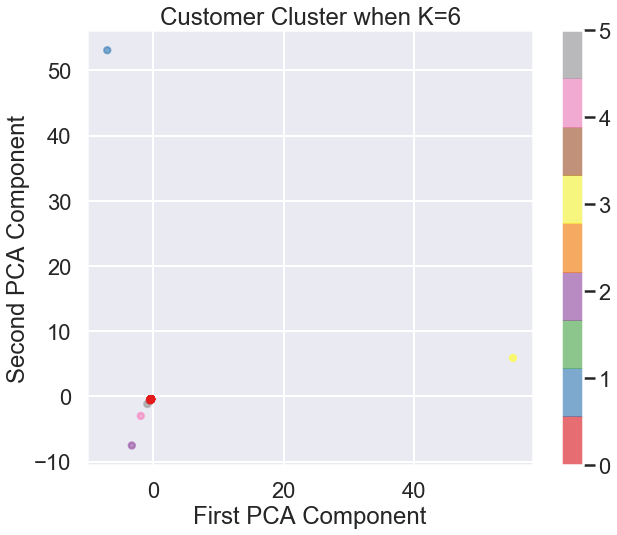

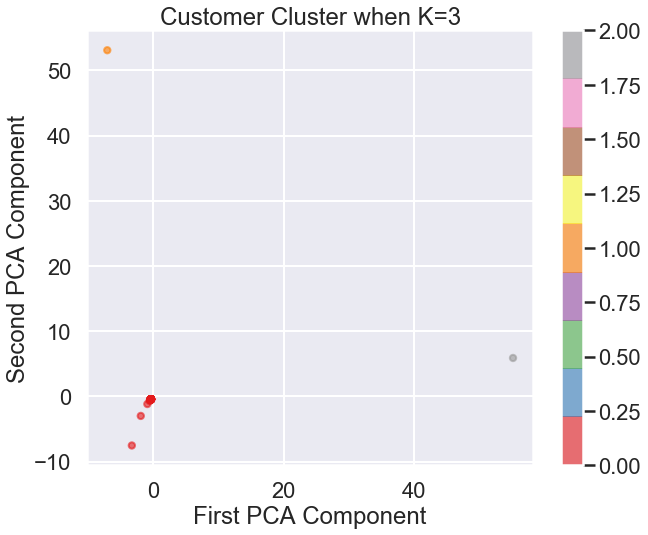

In [375]:
#plot x and y
plt.figure(figsize=(10,8))
plt.scatter(df_pca.x, df_pca.y, c=df_pca.Cluster_1, cmap='Set1', s=40, alpha=0.6)
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Component')
plt.title('Customer Cluster when K=6')
plt.colorbar()
plt.plot()

plt.figure(figsize=(10,8))
plt.scatter(df_pca.x, df_pca.y, c=df_pca.Cluster_2, cmap='Set1', s=40, alpha=0.6)
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Component')
plt.title('Customer Cluster when K=3')
plt.colorbar()
plt.plot();

In [377]:
#Create merged DataFrame
df_main = pd.merge(df_merge, df_pca, on='Specialty')
df_main.sort_values('Cluster_2').head()

,NPI,Specialty,N,Region,Opioid_Prescriber,Population,Cluster_1,Cluster_2,x,y
0,1710982582,Dentist,1,South,1,26448193,2,0,-3.328258,-7.529191
17205,1124071949,Obstetrics/Gynecology,1,South,1,19552860,0,0,-0.484432,-0.553120
17204,1629007224,Obstetrics/Gynecology,1,South,0,19552860,0,0,-0.484432,-0.553120
17203,1699985457,Obstetrics/Gynecology,1,South,1,19552860,0,0,-0.484432,-0.553120
17202,1851353650,Obstetrics/Gynecology,1,South,0,19552860,0,0,-0.484432,-0.553120


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

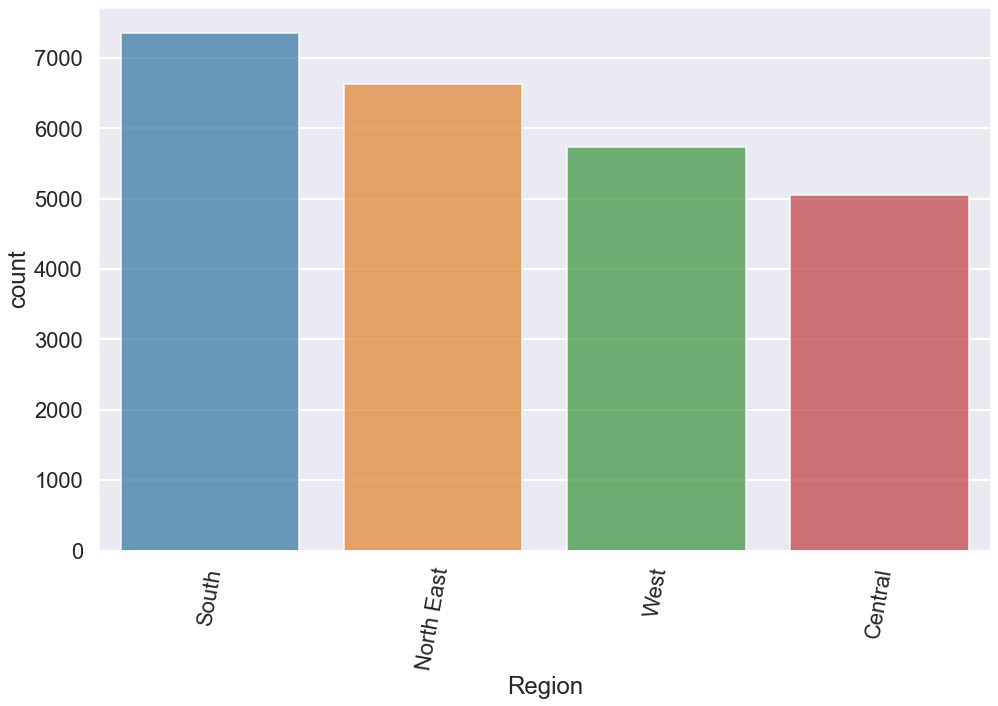

In [383]:
plt.figure(figsize=(16,10))
sns.countplot(x='Region',data=df_main,alpha=0.7)
plt.xticks(rotation=80)

[]

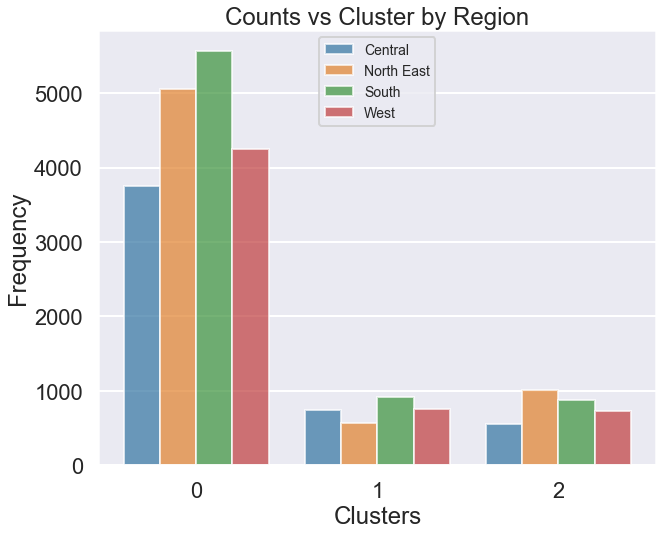

In [385]:
clust_group = df_main.groupby(['Cluster_2', 'Region']).Specialty.count().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='Cluster_2', y='Specialty', data=clust_group, hue='Region', alpha=0.7)
plt.xlabel('Clusters')
plt.ylabel('Frequency')
plt.title('Counts vs Cluster by Region')
plt.legend(loc= 'upper center', prop={'size': 14})
plt.plot()

(0, 10)

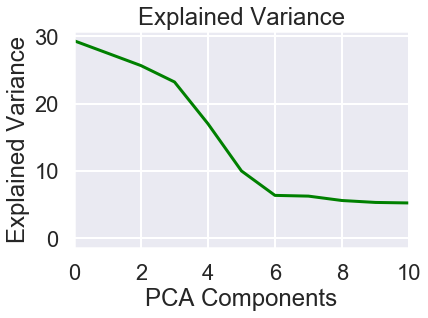

In [386]:
# Initialize a new PCA model with a default number of components.
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
plt.plot(pca.explained_variance_, c='g', linewidth=3)
plt.title('Explained Variance')
plt.xlabel('PCA Components')
plt.ylabel('Explained Variance')
plt.xlim([0, 10])

In [387]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [388]:
numbs_ap = [0,0]

for damping in np.arange(.5,1,0.1):
    afp = AffinityPropagation(damping=damping).fit(x_cols)
    afp_labels = afp.fit_predict(x_cols)
    numbs_ap.append(metrics.silhouette_score(x_cols, afp_labels, metric='sqeuclidean'))
    
print('Estimated number of clusters: %d' % damping)
print('Silhouette Coefficient: %0.3f' % metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'))

affinity_propagation = metrics.silhouette_score(x_cols, afp_labels, metric='sqeuclidean')

Estimated number of clusters: 0
Silhouette Coefficient: 0.851


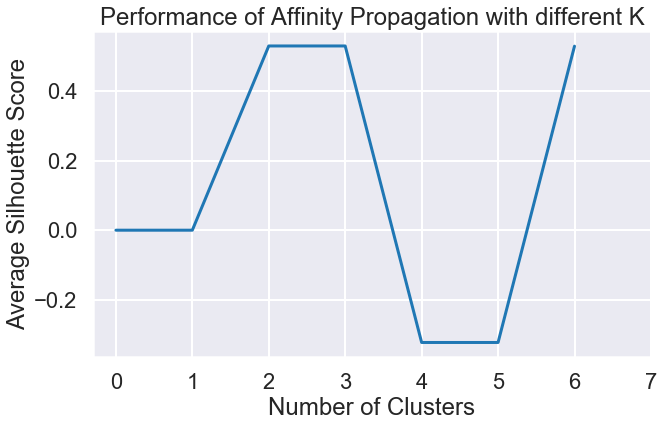

In [389]:
plt.figure(figsize=(10,6))
plt.plot(numbs_ap)
plt.xticks(range(0,8))
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Performance of Affinity Propagation with different K')
plt.show()

In [394]:
from sklearn.cluster import AgglomerativeClustering

In [395]:
numbs_ag=[0,0]

for clusters in range(2,56):
    agg_cluster = AgglomerativeClustering(n_clusters= clusters, linkage='complete')
    model = agg_cluster.fit_predict(x_cols)
    numbs_ag.append(metrics.silhouette_score(x_cols, labels=model, metric='sqeuclidean'))
    
agglomerative_clust = AgglomerativeClustering(n_clusters = 2, linkage='complete').fit(x_cols)

print('Estimated number of clusters: %d' % clusters)
print('Silhouette Coefficient: %0.3f' % metrics.silhouette_score(x_cols, agglomerative_clust.labels_, metric='sqeuclidean'))

agglomerative_clustering = metrics.silhouette_score(x_cols, agglomerative_clust.labels_, metric='sqeuclidean')

Estimated number of clusters: 55
Silhouette Coefficient: 0.884


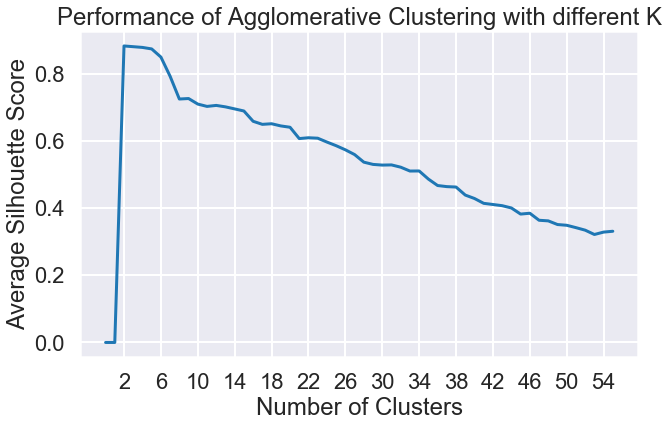

In [396]:
plt.figure(figsize=(10,6))
plt.plot(numbs_ag)
plt.xticks(range(2,57,4))
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Performance of Agglomerative Clustering with different K')
plt.show()

In [402]:
print('Silhouette Scores')
print('Affinity Propagation: ', affinity_propagation)
print('Agglomerative Clustering: ', agglomerative_clustering)

Silhouette Scores
Affinity Propagation:  0.5290229861886726
Agglomerative Clustering:  0.884271735608119


## Creating Predictions for Opioid Prescribers

In [425]:
df3 = prescriber
df3 = df3.drop(df3[['Abbrev', 'Specialty', 'SumOpi', 'TotPresc', 'NonOpi']], axis=1)
df3

,NPI,Gender,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,...,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid_Prescriber,Region,Population,Deaths,Spec_group
0,1710982582,M,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,South,26448193,2601,group1
1,1023260569,M,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,South,26448193,2601,group1
2,1659334472,M,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,South,26448193,2601,group1
3,1952598419,F,0,0,16,0,0,0,0,22,...,40,54,0,0,12,1,South,26448193,2601,group1
4,1043399322,M,0,23,0,0,0,0,0,12,...,0,0,0,0,0,1,South,26448193,2601,group1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24754,1841302700,M,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,Central,844877,63,group1
24755,1336293323,F,20,0,0,0,0,0,0,16,...,0,0,0,52,59,0,Central,844877,63,group1
24756,1851630727,M,13,0,0,0,0,0,14,0,...,12,0,0,0,0,1,Central,844877,63,group1
24757,1447239942,F,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,Central,844877,63,group1


In [417]:
# Let's now create our training and test data.
train,test = train_test_split(df3,test_size = 0.2,random_state = 42)
print(train.shape)
print(test.shape)

(19807, 257)
(4952, 257)


In [419]:
# Now we convert our categorical columns.
Categorical_columns = ['Gender','Region','Spec_group']

for col in Categorical_columns:
    train[col] = pd.factorize(train[col], sort = True)[0]
    test[col] = pd.factorize(test[col],sort = True)[0]

C:\Users\Jimsyd\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Jimsyd\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [420]:
# Set our features.
features = train.iloc[:,1:] #make sure we only use the columns that we want as our features
features.head()

,Gender,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,...,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid_Prescriber,Region,Population,Deaths,Spec_group
11188,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12882135,1705,0
17083,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9895622,1762,0
14198,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,3,38332521,4521,0
14311,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,38332521,4521,0
12246,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,1015165,125,0


In [37]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [434]:
features = train.iloc[:,0:242]

# Make sure to remove the target Opioid_Prescriber
target = train['Opioid_Prescriber']

Name = []
Accuracy = []
model1 = LogisticRegression(random_state = 22,C = 0.000000001,solver = 'liblinear',max_iter = 200)
model2 = GaussianNB()
model3 = RandomForestClassifier(n_estimators = 200,random_state = 22)
model4 = GradientBoostingClassifier(n_estimators = 200)
model5 = KNeighborsClassifier()
model6 = DecisionTreeClassifier()
model7 = LinearDiscriminantAnalysis()
model8 = BaggingClassifier()
Ensembled_model = VotingClassifier(estimators = [('lr', model1), ('gn', model2), ('rf', model3),('gb',model4),('kn',model5),('dt',model6),('lda',model7), ('bc',model8)], voting = 'hard')

for model, label in zip([model1, model2, model3, model4,model5,model6,model7,model8,Ensembled_model], ['Logistic Regression','Naive Bayes','Random Forest', 'Gradient Boosting','KNN','Decision Tree','LDA', 'Bagging Classifier', 'Ensemble']):
    scores = cross_val_score(model, features, target, cv = 5, scoring = 'accuracy')
    Accuracy.append(scores.mean())
    Name.append(model.__class__.__name__)
    print("Accuracy: %f of model %s" % (scores.mean(),label))

Accuracy: 0.589590 of model Logistic Regression
Accuracy: 0.589590 of model Naive Bayes
Accuracy: 0.920129 of model Random Forest
Accuracy: 0.925834 of model Gradient Boosting
Accuracy: 0.533851 of model KNN
Accuracy: 0.890342 of model Decision Tree
Accuracy: 0.755843 of model LDA
Accuracy: 0.921140 of model Bagging Classifier
Accuracy: 0.912506 of model Ensemble


In [438]:
from sklearn.metrics import accuracy_score
classifers = [model3,model4,model8]
out_sample_accuracy = []
Name_2 = []
for each in classifers:
    fit = each.fit(features,target)
    pred = fit.predict(test.iloc[:,1:243])
    accuracy = accuracy_score(test['Opioid_Prescriber'],pred)
    Name_2.append(each.__class__.__name__)
    out_sample_accuracy.append(accuracy)

In [439]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
y_actu = test['Opioid_Prescriber']
confusion_matrix(y_actu, pred)

array([[1493,  599],
       [1628, 1232]], dtype=int64)

In [440]:
# Precision-Recall Curve
sklearn.metrics.precision_recall_curve(y_actu, pred, pos_label = None, sample_weight = None)

(array([0.57754443, 0.67285636, 1.        ]),
 array([1.        , 0.43076923, 0.        ]),
 array([0, 1], dtype=int64))

In [441]:
# Precision-Recall Score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_actu, pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.62


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.62')

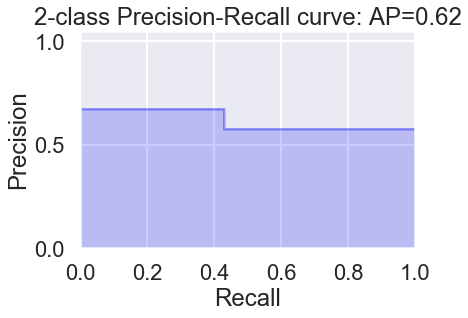

In [442]:
# Precision-Recall Curve Plot
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_actu, pred)

plt.step(recall, precision, color = 'b', alpha = 0.2,
         where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha = 0.2,
                 color = 'b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

## DataCamp Course

In [443]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Create arrays for the features and the response variable
y2 = df2['Opioid_Prescriber'].values
X2 = df2.drop('Opioid_Prescriber', axis=1).values

# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X2,y2)

# Predict the labels for the training data X
y_pred = knn.predict(X2)

# Predict and print the label for the new data point X_new
print("Prediction: {}".format(y_pred))

Prediction: [0 0 0 ... 1 0 1]


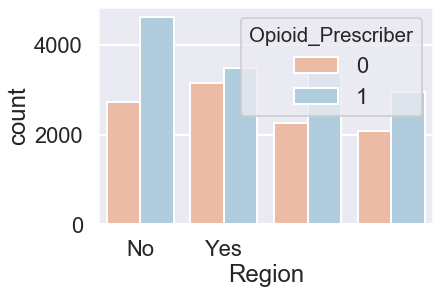

In [240]:
plt.figure()
sns.countplot(x='Region', hue='Opioid_Prescriber', data=prescriber, palette='RdBu')
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

In [444]:
# Split into training and test set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state=42, stratify=y)

# Fit the classifier to the training data
knn.fit(X_train2, y_train2)

# Print the accuracy
print(knn.score(X_test2, y_test2))

0.510702746365105


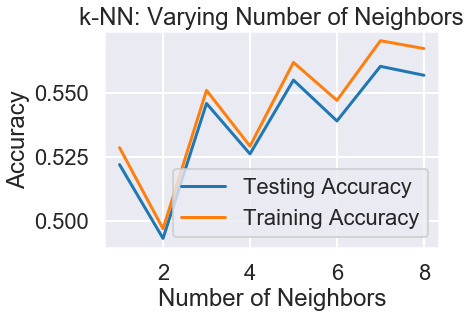

In [446]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors= k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

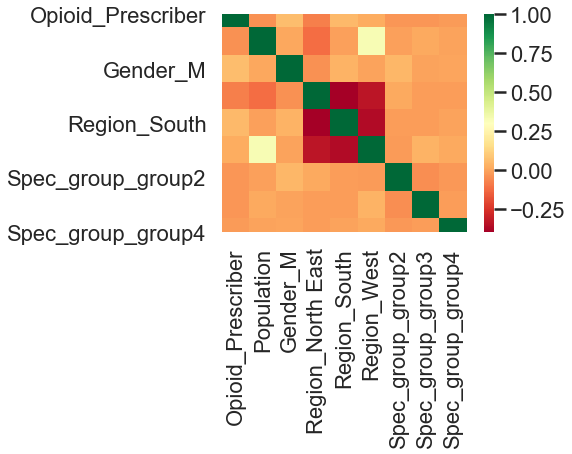

In [260]:
sns.heatmap(df2.corr(), square=True, cmap='RdYlGn')

In [265]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))


R^2: 0.018156497897916735
Root Mean Squared Error: 0.488622783106005


In [266]:
# Import the necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X, y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.02957017 0.00246499 0.0049506  0.00042144 0.01291008]
Average 5-Fold CV Score: 0.010063455848461689


In [267]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
reg = LinearRegression()

# Perform 3-fold CV
cvscores_3 = cross_val_score(reg, X, y, cv=3)
print(np.mean(cvscores_3))

# Perform 10-fold CV
cvscores_10 = cross_val_score(reg, X, y, cv=10)
print(np.mean(cvscores_10))

0.008520030239666965
0.008741294580028869


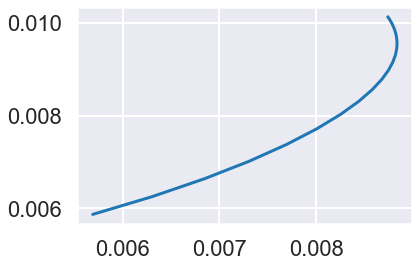

In [277]:
# Import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
plt.plot(ridge_scores, ridge_scores_std)

In [278]:
# Import necessary modules
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.4, random_state= 42)

# Instantiate a k-NN classifier: knn
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the training data
knn.fit(X_train,y_train)

# Predict the labels of the test data: y_pred
y_pred = knn.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[1851 2272]
 [2246 3535]]
              precision    recall  f1-score   support

           0       0.45      0.45      0.45      4123
           1       0.61      0.61      0.61      5781

    accuracy                           0.54      9904
   macro avg       0.53      0.53      0.53      9904
weighted avg       0.54      0.54      0.54      9904



In [279]:
# Import the necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   0 4123]
 [   0 5781]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4123
           1       0.58      1.00      0.74      5781

    accuracy                           0.58      9904
   macro avg       0.29      0.50      0.37      9904
weighted avg       0.34      0.58      0.43      9904



C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


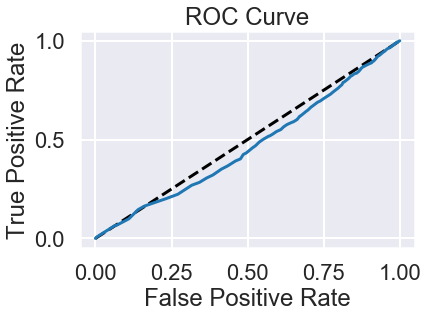

In [280]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [281]:
# Import necessary modules
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.4658251794845266
AUC scores computed using 5-fold cross-validation: [0.46860494 0.55663084 0.5452147  0.36955133 0.49978559]


In [282]:
# Import necessary modules
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 1e-05}
Best score is 0.5871804192414879


In [283]:
# Import necessary modules
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 7}
Best score is 0.5817682458903833


In [284]:
# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the training data
logreg_cv.fit(X_train,y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 1e-05, 'penalty': 'l1'}
Tuned Logistic Regression Accuracy: 0.5894984853584652


In [285]:
# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1435.2829850771088, tolerance: 0.28817287108717665
  positive)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1433.8898400887444, tolerance: 0.2877874453046118
  positive)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1430.5289902076643, tolerance: 0.2871025244025539
  positive)
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Du

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.006496956805064236
Tuned ElasticNet MSE: 0.24141499535731847


C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1790.9168029623816, tolerance: 0.35947617637159374
  positive)


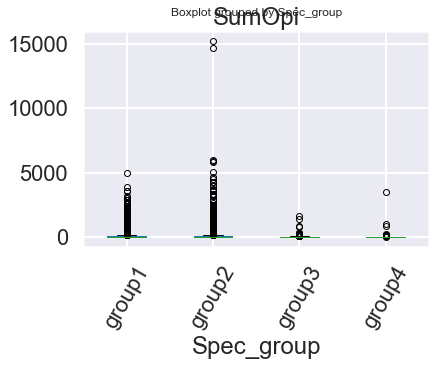

In [292]:
# Create a boxplot of life expectancy per region
prescriber.boxplot('SumOpi', 'Spec_group', rot=60)

# Show the plot
plt.show()


In [293]:
# Import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Instantiate a ridge regressor: ridge
ridge = Ridge(alpha=0.5, normalize=True)

# Perform 5-fold cross-validation: ridge_cv
ridge_cv = cross_val_score(ridge, X, y, cv=5)

# Print the cross-validated scores
print(ridge_cv)

[0.02145987 0.00307367 0.00454163 0.0030464  0.01044099]


In [307]:
# Import scale
from sklearn.preprocessing import scale

# Scale the features: X_scaled
X_scaled = scale(X)

# Print the mean and standard deviation of the unscaled features
print("Mean of Unscaled Features: {}".format(np.mean(X))) 
print("Standard Deviation of Unscaled Features: {}".format(np.std(X)))

# Print the mean and standard deviation of the scaled features
print("Mean of Scaled Features: {}".format(np.mean(X_scaled))) 
print("Standard Deviation of Scaled Features: {}".format(np.std(X_scaled)))

Mean of Unscaled Features: 1661445.6490771032
Standard Deviation of Unscaled Features: 5816084.105864511
Mean of Scaled Features: 5.919037087544758e-19
Standard Deviation of Scaled Features: 0.9999999999999999


In [309]:
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
knn_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
knn_unscaled = KNeighborsClassifier().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(knn_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(knn_unscaled.score(X_test, y_test)))


Accuracy with Scaling: 0.5434841141626279
Accuracy without Scaling: 0.5550619278406032


In [298]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01]}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=21)

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters, cv=3)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))


Accuracy: 0.6017770597738288
              precision    recall  f1-score   support

           0       0.55      0.18      0.27      2041
           1       0.61      0.90      0.73      2911

    accuracy                           0.60      4952
   macro avg       0.58      0.54      0.50      4952
weighted avg       0.59      0.60      0.54      4952

Tuned Model Parameters: {'SVM__C': 100, 'SVM__gamma': 0.1}
